In [1]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
train_images=sorted(os.listdir('gdrive/My Drive/Kaggle/Medical Images'))

In [3]:
train_image=[]
for im in train_images:
  img=image.load_img('gdrive/My Drive/Kaggle/Medical Images/'+im,target_size=(64,64),color_mode='grayscale')
  img=image.img_to_array(img)
  img=img/255
  train_image.append(img)

train_df=np.array(train_image)

In [4]:
#Subplotting images
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
  plt.show()

In [5]:
#Adding gaussian noise with 0.1 factor
def add_noise(image):
  row,col,ch=image.shape
  mean=0
  sigma=1
  gauss=np.random.normal(mean,sigma,(row,col,ch))
  gauss=gauss.reshape(row,col,ch)
  noisy=image+gauss*0.1
  return noisy

In [6]:
noised_df=[]
for img in train_df:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)

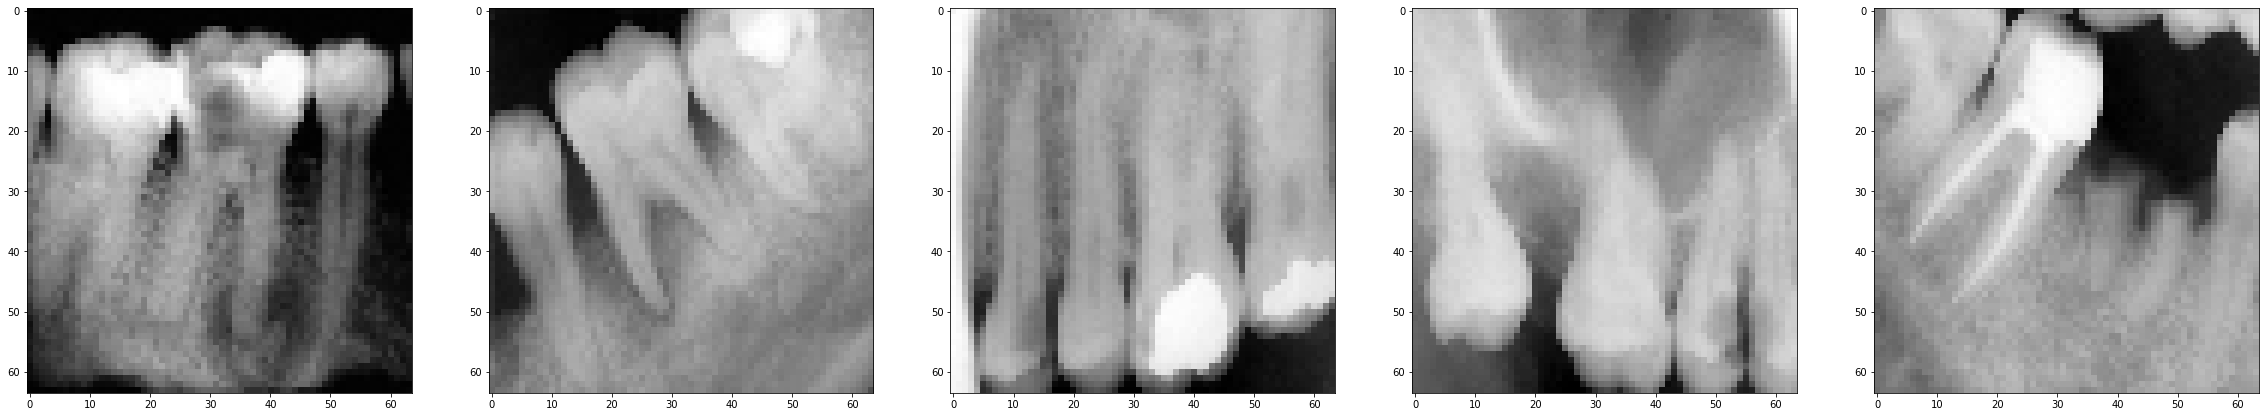

In [7]:
plot_img(train_df)

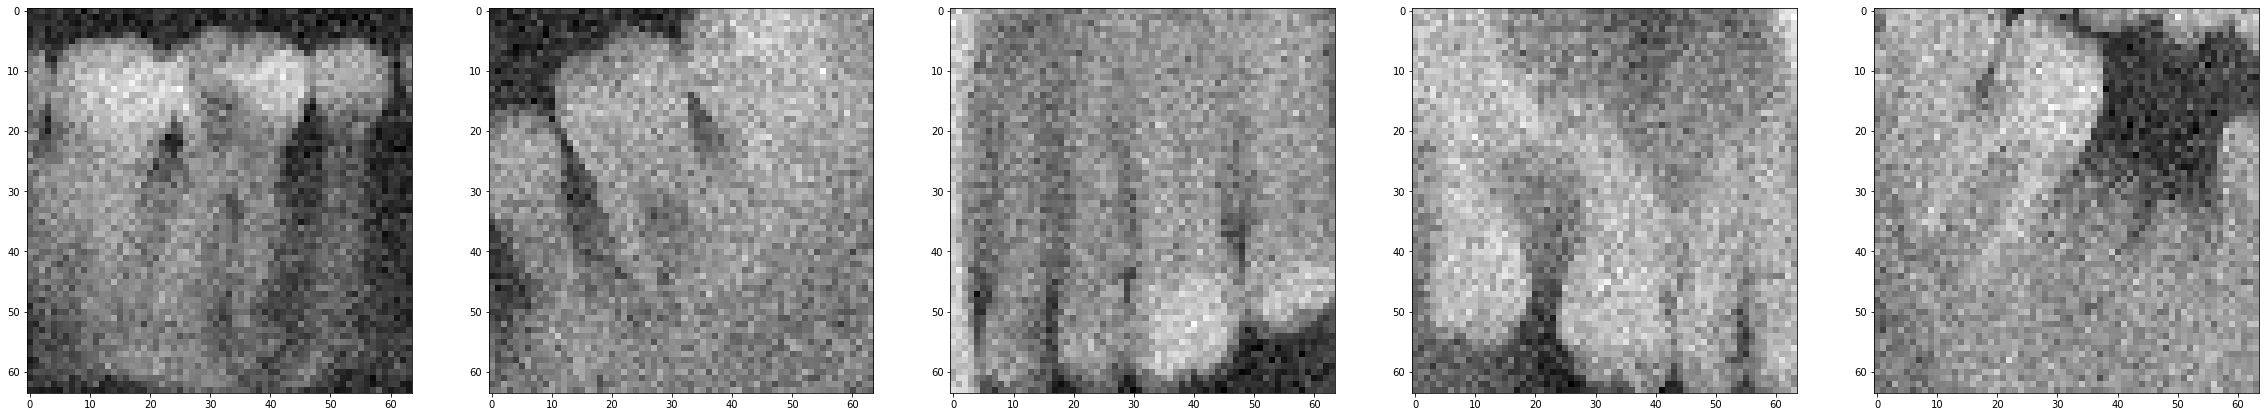

In [8]:
plot_img(noised_df)

In [9]:
xnoised=noised_df[:100]
xtest=noised_df[100:]

In [10]:
def autoencoder():
  input_img=Input(shape=(64,64,1),name='image_input')
  #enoder 
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
   
  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
   
  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
  return autoencoder

In [11]:
model= autoencoder()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 64, 64, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 32, 32, 64)       

In [12]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=40, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/40
10/10 [==============================] - 3s 288ms/step - loss: 0.6676 - val_loss: 0.6411
Epoch 2/40
10/10 [==============================] - 3s 274ms/step - loss: 0.6100 - val_loss: 0.5954
Epoch 3/40
10/10 [==============================] - 3s 275ms/step - loss: 0.5893 - val_loss: 0.5847
Epoch 4/40
10/10 [==============================] - 3s 273ms/step - loss: 0.5797 - val_loss: 0.5798
Epoch 5/40
10/10 [==============================] - 3s 270ms/step - loss: 0.5748 - val_loss: 0.5740
Epoch 6/40
10/10 [==============================] - 3s 271ms/step - loss: 0.5704 - val_loss: 0.5729
Epoch 7/40
10/10 [==============================] - 3s 273ms/step - loss: 0.5679 - val_loss: 0.5705
Epoch 8/40
10/10 [==============================] - 3s 268ms/step - loss: 0.5661 - val_loss: 0.5679
Epoch 9/40
10/10 [==============================] - 3s 271ms/step - loss: 0.5638 - val_loss: 0.5657
Epoch 10/40
10/10 [==============================] - 3s 270ms/step - loss: 0.5623 - val_loss: 0.5643

In [13]:
xtrain= train_df[100:]

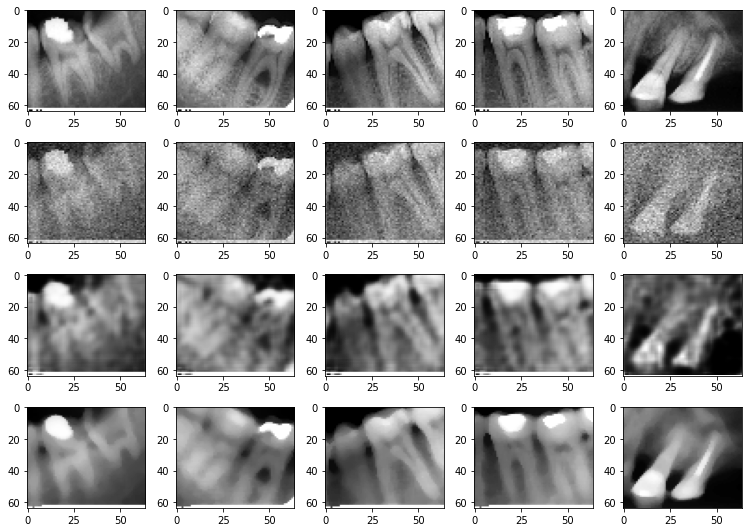

In [25]:
pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

Text(0.5, 1.0, 'Bilateral Filter')

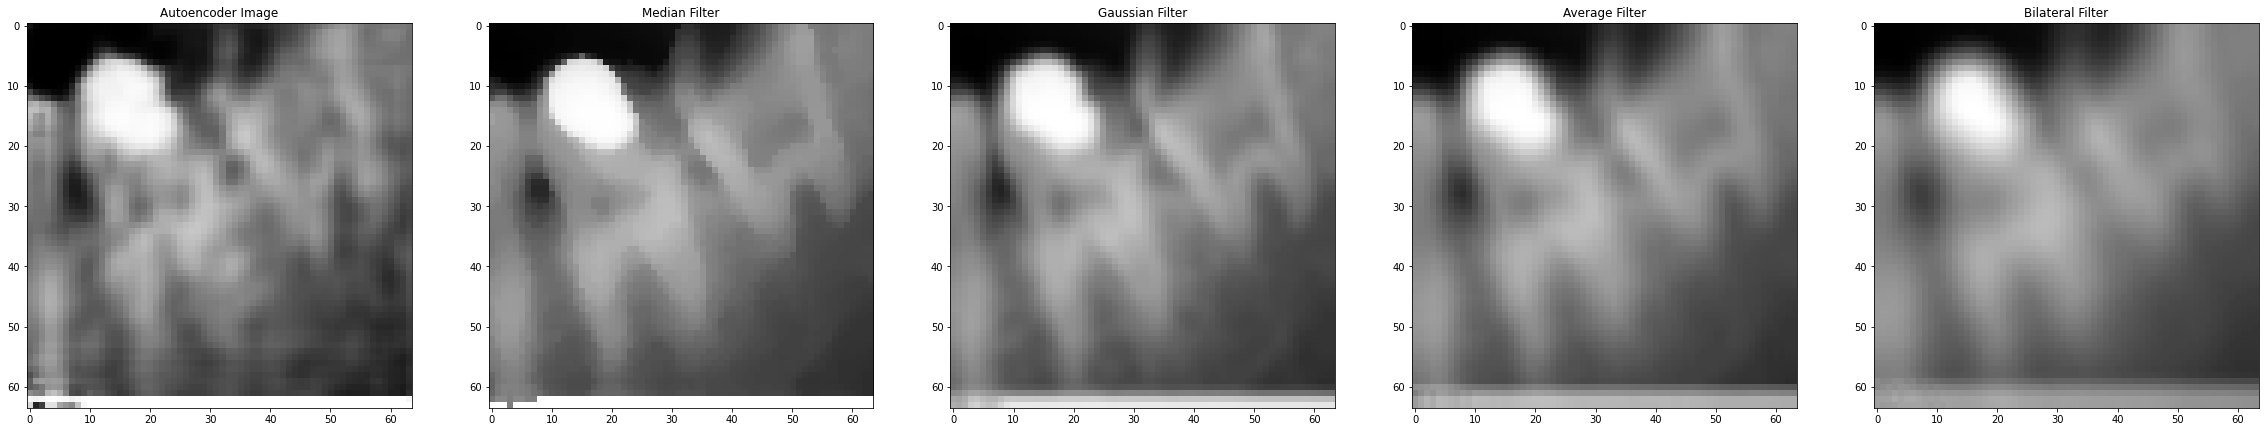

In [41]:
median_blur = cv2.medianBlur(xtrain[0], (5))
gaussian_blur=cv2.GaussianBlur(xtrain[0],(5,5),0)
average_blur=cv2.blur(xtrain[0],(5,5))
bilateral_filter=cv2.bilateralFilter(xtrain[0],9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0].reshape(64,64), cmap='gray')
ax[0].set_title('Autoencoder Image')
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter')
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter')
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter')

In [44]:
def PSNR(original, denoised): 
    mse = np.mean((original - denoised) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

  
value1 = PSNR(xtest[0], median_blur)
value2 = PSNR(xtest[0], pred[0])
value3 = PSNR(xtest[0], gaussian_blur)
value4 = PSNR(xtest[0], average_blur)
value5 = PSNR(xtest[0], bilateral_filter)

print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")

PSNR values
Autoencoder Image : 67.63551773137632 dB
Median Filter Image : 58.25077105285307 dB
Gaussian Filter Image : 58.52736539942087 dB
Average Filter Image : 58.76549212436193 dB
Bilateral Filter Image : 58.997631051500015 dB
